In [10]:
import gensim
import os
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim.models.doc2vec import TaggedDocument
from nltk.corpus import stopwords
import pickle
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
pd.options.display.max_colwidth = 500
from sklearn.cross_validation import train_test_split

import os
os.environ['MKL_NUM_THREADS'] = '20'
os.environ['GOTO_NUM_THREADS'] = '20'
os.environ['OMP_NUM_THREADS'] = '20'
os.environ['openmp'] = 'True'

### Read file

In [11]:
# read file
os.chdir("/deeplearning/data")
directory = os.getcwd()
filepath=r"/tweets_data/train.csv"
tweets_df = pd.read_csv(directory+filepath)

In [12]:
tweets_df.loc[tweets_df["sentiment"]==4,"sentiment"] = 1

In [13]:
# tweets_df = pd.concat([tweets_df[1:6000],tweets_df[-6000:-1]],axis=0)
tweets_df.shape

(1600000, 6)

### Clean text

In [14]:
def review_to_words( raw_review ):
    review_text = BeautifulSoup(raw_review).get_text()
    review_text = review_text.lower()
    #REMOVE LINKS
    review_text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', review_text)
    #remove at-mentions
    review_text = review_text.replace(".","")
    review_text = re.sub(r'@.*?(?=\s)', '', review_text)
    review_text = review_text.replace("#","").split()
#     review_text = re.sub(r'^\+feedback', '', review_text)
#     letters_only = re.sub("[^a-zA-Z]", " ", review_text)     
#     words = letters_only.lower().split()
#    wordsList.extend(words)
#     stops = set(stopwords.words("english"))                  
#     meaningful_words = [w for w in words if not w in stops]   
    return( " ".join( review_text ))      

tweets_df["clean_text"] = tweets_df["text"].apply(lambda x: review_to_words(x))

/home/kinshuk/anaconda2/envs/python3/lib/python3.4/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 170 of the file /home/kinshuk/anaconda2/envs/python3/lib/python3.4/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html.parser")

  markup_type=markup_type))


KeyboardInterrupt: 

### train-test split

In [28]:
Y = tweets_df["sentiment"]
X = tweets_df["clean_text"]

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### Read cleaned csv files

In [72]:
x_train = pd.read_csv(directory + "/cleaned_data/x_train.csv")
x_train.columns = ["id", "text"]
x_train["text"] = x_train["text"].astype('str')

x_test = pd.read_csv(directory + "/cleaned_data/x_test.csv")
x_test.columns = ["id", "text"]
x_test["text"] = x_train["text"].astype('str')

y_train = pd.read_csv(directory + "/cleaned_data/y_train.csv")
y_test = pd.read_csv(directory + "/cleaned_data/y_test.csv")


In [73]:
x_train["length"] = x_train["text"].apply(lambda x: len((x).split()))

x_test["length"] = x_test["text"].apply(lambda x: len((x).split()))
x_test.head()

,id,text,length
0,1598617,you're most welcome,3
1,620181,i wanted to see the tony awards i had to work,11
2,76767,"flooring picked out, that was easy! she had everything laid out for us now off to the amish craft store with mia and sue",24
3,1394882,oh my shiznit he actually replied to you! how sweet haha,11
4,900229,of course!,2


In [66]:
x_train[x_train["length"] > 9].shape

(1126285, 3)

In [75]:
x_test[x_test["length"] > 9].shape

(193611, 3)

### Creating tagged docs

In [74]:
def create_tagged_doc(sentences):
    taggeddoc = []
    for index,i in enumerate(sentences):
        td = TaggedDocument(gensim.utils.to_unicode(str.encode(i)).split(),[index])
        taggeddoc.append(td)
    return taggeddoc
taggeddoc = create_tagged_doc(x_train["text"])
taggeddoc[:2]

[TaggedDocument(words=["you're", 'most', 'welcome'], tags=[0]),
 TaggedDocument(words=['i', 'wanted', 'to', 'see', 'the', 'tony', 'awards', 'i', 'had', 'to', 'work'], tags=[1])]

### Model Training

In [ ]:
from gensim.models import doc2vec
import pickle
import time
from random import shuffle

num_features = 5 #number of features/columns for the term-document matrix.

min_word_count = 10 # ''' minimum word count: any word that does not occur at least this many times across all documents is ignored'''
context = 3 # Context window size. The paper (http://arxiv.org/pdf/1405.4053v2.pdf) suggests 10 is the optimal

downsampling = 1e-3  # ''' threshold for configuring which higher-frequency words are randomly downsampled; default is 0 (off), useful value is 1e-5 set the same as word2vec'''

num_workers = 20  # Number of threads to run in parallel

# build the Doc2vec model
model = doc2vec.Doc2Vec(taggeddoc, dm=1, size=num_features,
                        window=context, min_count=min_word_count,
                        workers=num_workers,alpha=0.05,min_alpha=0.025)

# model = doc2vec.Doc2Vec(taggeddoc, dm = 1, alpha=0.025, window=5, size= 10, min_alpha=0.025, min_count=1)

# model.build_vocab(taggeddoc)

# start training
for epoch in range(1,5):    
    print("Starting Epoch ",epoch)    
    start_time = time.time()    
    #Shuffle the tagged cleaned up reviews in each epoch
    shuffle(taggeddoc)
    
    model.train(taggeddoc, total_examples=model.corpus_count, epochs=model.iter)
#     model.alpha -= 0.02
#     model.min_alpha = model.alpha
    print("Epoch ",epoch," took %s minutes " % ((time.time() - start_time)/60))

gensim_vectors = []
for item in x_train:
    gensim_vectors.append(model.infer_vector(item.split()))

#Save the trained model	
model.save("Doc2VecTaggedDocs_5_3")


Starting Epoch  1
Epoch  1  took 13.403189329306285 minutes 
Starting Epoch  2
Epoch  2  took 13.244980490207672 minutes 
Starting Epoch  3
Epoch  3  took 13.133060296376547 minutes 
Starting Epoch  4


### Assessing the model

In [49]:
ranks = []
second_ranks = []
for doc_id in range(len(taggeddoc)):
    inferred_vector = model.infer_vector(taggeddoc[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    second_ranks.append(sims[1])

KeyboardInterrupt: 

In [13]:
# Let's count how each document ranks with respect to the training corpus
import collections
collections.Counter(ranks)  # Results vary due to random seeding and very small corpus

Counter({0: 1,
         1: 1,
         2: 2,
         6: 2,
         8: 2,
         9: 1,
         11: 1,
         14: 1,
         16: 1,
         17: 2,
         18: 2,
         19: 2,
         20: 2,
         23: 2,
         24: 1,
         25: 1,
         26: 1,
         28: 1,
         29: 2,
         30: 2,
         31: 1,
         33: 4,
         34: 2,
         35: 1,
         36: 2,
         38: 1,
         39: 1,
         40: 3,
         43: 2,
         46: 1,
         47: 2,
         48: 1,
         49: 1,
         57: 1,
         59: 1,
         60: 2,
         61: 3,
         62: 4,
         63: 1,
         66: 1,
         67: 1,
         68: 3,
         70: 1,
         73: 2,
         74: 1,
         76: 1,
         78: 2,
         79: 1,
         80: 2,
         83: 1,
         84: 2,
         85: 1,
         86: 2,
         90: 2,
         91: 1,
         92: 3,
         93: 1,
         94: 2,
         96: 1,
         97: 1,
         98: 1,
         99: 2,
         102: 

In [32]:
### Basically, greater than 95% of the inferred documents are found to be most similar to itself and about 5% of the time it is mistakenly most similar to another document. the checking of an inferred-vector against a training-vector is a sort of 'sanity check' as to whether the model is behaving in a usefully consistent manner, though not a real 'accuracy' value.
# This is great and not entirely surprising. We can take a look at an example:
# This is great and not entirely surprising. We can take a look at an example:
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(taggeddoc[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(taggeddoc[sims[index][0]].words)))

NameError: name 'doc_id' is not defined

In [33]:
import random
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(taggeddoc))

# Compare and print the most/median/least similar documents from the train corpus
print('Train Document ({}): «{}»\n'.format(doc_id, ' '.join(taggeddoc[doc_id].words)))
sim_id = second_ranks[doc_id]
print('Similar Document {}: «{}»\n'.format(sim_id, ' '.join(taggeddoc[sim_id[0]].words)))

Train Document (874564): «maths exam»



NameError: name 'second_ranks' is not defined

## Test corpus

In [34]:
# get test data in shape
test_corpus = x_test.apply(lambda x :x.split()).tolist()

In [35]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_corpus))
inferred_vector = model.infer_vector(test_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(taggeddoc[sims[index][0]].words)))

Test Document (70049): «oh, a chicken hat, of course! i don't know why i didn't think of that»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d300,n5,w8,mc20,s0.001):

MOST (776027, 0.5999734401702881): «sad i might not go meet this weekend u dont know how much i love them ughh my mom said she doesnt know the road of»

MEDIAN (534258, 0.2017820179462433): «i was on campus for a grand total of 20 minutes today i love short days»

LEAST (669181, -0.5480166673660278): «well they certainly don't know you then»



### Get vectors for test data

In [38]:
gensim_vectors_test = []
for item in x_test:
    gensim_vectors_test.append(model.infer_vector(item.split()))

### Save vectors

In [41]:
with open(directory+'/embeddings/train_vectors.txt', 'wb') as fp:
    pickle.dump(gensim_vectors, fp, protocol=2)

with open(directory+'/embeddings/train_label.txt', 'wb') as fp:
    pickle.dump(y_train, fp, protocol=2)

with open(directory+'/embeddings/test_vectors.txt', 'wb') as fp:
    pickle.dump(gensim_vectors_test, fp, protocol=2)
    
with open(directory+'/embeddings/test_label.txt', 'wb') as fp:
    pickle.dump(y_test, fp, protocol=2)

In [37]:
### Save cleaned file
x_train.to_csv(directory+"/cleaned_data/x_train.csv")
x_test.to_csv(directory+"/cleaned_data/x_test.csv")
y_train.to_csv(directory+"/cleaned_data/y_train.csv")
y_test.to_csv(directory+"/cleaned_data/y_test.csv")

### Similar docs and all random stuff

In [1]:
print(type(model.syn0_lockf.shape))

# access individual word vector
# returns a 1 * # of features numpy array
# print(model["good"])

# doesnt_match function tries to deduce which word in a set is most
# dissimilar from the others
# print(model.doesnt_match("".split()) + '\n')

# most_similar(): returns the score of the most similar words based on the criteria
# Find the top-N most similar words. Positive words contribute positively towards the
# similarity, negative words negatively.

print("most similar:")
# print(model.most_similar(positive=['hate', 'bad'], negative=['hate'], topn=10))
print(model.most_similar(positive=['bad']))

# print(model.docvecs.most_similar(str(0)))

NameError: name 'model' is not defined

### Loading saved model

In [9]:
#loading the model
d2v_model = gensim.models.doc2vec.Doc2Vec.load(directory+"/saved_models/Doc2VecTaggedDocs_300_8")
#start testing
# printing the vector of document at index 1 in docLabels
docvec = d2v_model.docvecs[2]
print (len(docvec))

300


### Load vectors

In [8]:
with open (directory+'/embeddings/train_vectors.txt', 'rb') as fp:
    train_vectors = pickle.load(fp)

with open (directory+'/embeddings/train_label.txt', 'rb') as fp:
    train_label = pickle.load(fp)

with open (directory+'/embeddings/test_vectors.txt', 'rb') as fp:
    test_vectors = pickle.load(fp)

with open (directory+'/embeddings/test_label.txt', 'rb') as fp:
    test_label = pickle.load(fp)

In [9]:
with open(directory+'/embeddings/train_vectors.txt', 'wb') as fp:
    pickle.dump(train_vectors, fp, protocol=2)

with open(directory+'/embeddings/train_label.txt', 'wb') as fp:
    pickle.dump(train_label, fp, protocol=2)

with open(directory+'/embeddings/test_vectors.txt', 'wb') as fp:
    pickle.dump(test_vectors, fp, protocol=2)
    
with open(directory+'/embeddings/test_label.txt', 'wb') as fp:
    pickle.dump(test_label, fp, protocol=2)

# Use embeddings from above to build a sentiment classification model

In [15]:
from sklearn.linear_model import SGDClassifier

lr = SGDClassifier(loss='log', penalty='l1')
lr.fit(train_vectors, train_label)

print (lr.score(test_vectors, test_label))

0.504246875


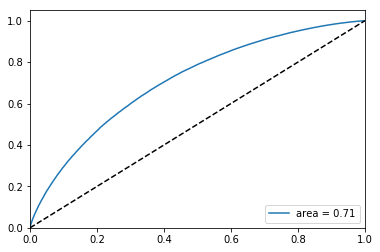

In [167]:
#Create ROC curve
from sklearn.metrics import roc_curve, auc
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

pred_probas = lr.predict_proba(gensim_vectors_test)[:,1]

fpr,tpr,_ = roc_curve(y_test, pred_probas)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

plt.show()

In [ ]:
# from sklearn.svm import SVC # "Support vector classifier"
# clf = SVC(kernel='rbf', C=1E6)
# clf.fit(X, y)

In [50]:
len(gensim_vectors)

1280000

### Neural Net

In [51]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)

# create model
model = Sequential()
model.add(Dense(20, input_dim=300, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

ImportError: No module named 'keras'

In [ ]:
# Fit the model
model.fit(X, Y, epochs=5, batch_size=100000)

In [ ]:
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
### Random Forest

In [16]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

alg = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split = 20000, min_samples_leaf=10000)
# Compute the accuracy score for all of the cross validation folds; this is much simpler than what we did before
kf = cross_validation.KFold(y_train.shape[0], n_folds=3, random_state=1)
scores = cross_validation.cross_val_score(alg, train_vectors, y_train, cv=kf)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

#fitting the model
alg.fit(train_vectors, train_label)
print (alg.score(train_vectors, train_label))
# Predict Output
y_pred= alg.predict(test_vectors)

#test error
from sklearn.metrics import confusion_matrix

C = confusion_matrix(test_vectors,y_pred)
C

NameError: name 'y_train' is not defined

In [ ]:
# remove punctuations
def cleanText(corpus):
    punctuation = """.,?!:;(){}[]"""
    corpus = [z.lower().replace('\n','') for z in corpus]
    corpus = [z.replace('<br />', ' ') for z in corpus]

    #treat punctuation as individual words
    for c in punctuation:
        corpus = [z.replace(c, ' %s '%c) for z in corpus]
    corpus = [z.split() for z in corpus]
    return corpus

In [ ]:
#tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.70, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(feedback_data["feedback_cleaned"])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()